Epoch 0, Train Loss: 0.6455, Val Loss: 0.6455, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 10, Train Loss: 0.3546, Val Loss: 0.3546, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 20, Train Loss: 0.2304, Val Loss: 0.2304, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 30, Train Loss: 0.1667, Val Loss: 0.1667, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 40, Train Loss: 0.1291, Val Loss: 0.1291, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 50, Train Loss: 0.1047, Val Loss: 0.1047, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 60, Train Loss: 0.0877, Val Loss: 0.0877, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 70, Train Loss: 0.0752, Val Loss: 0.0752, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 80, Train Loss: 0.0656, Val Loss: 0.0656, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 90, Train Loss: 0.0581, Val Loss: 0.0581, Train Acc: 1.0000, Val Acc: 1.0000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        77

    accuracy                           1.00        77
   macr

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


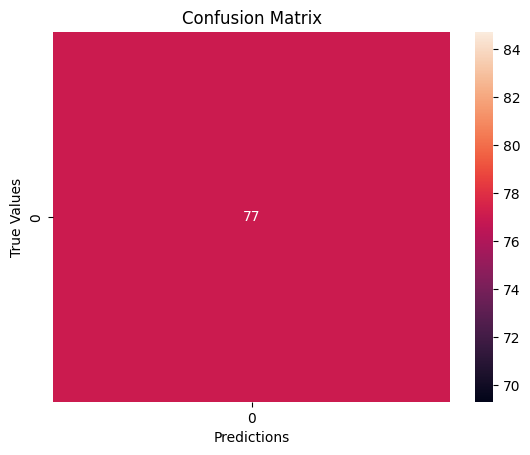

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Activation functions
def relu(x):
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(float)
    return result

def sigmoid(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid must be a numpy array"
    result = 1 / (1 + np.exp(-x))
    assert np.all((result >= 0) & (result <= 1)), "Sigmoid output must be in [0, 1]"
    return result

def sigmoid_derivative(x):
    assert isinstance(x, np.ndarray), "Input to sigmoid derivative must be a numpy array"
    result = sigmoid(x) * (1 - sigmoid(x))
    return result

# NeuralNetwork class
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.rand(layer_sizes[i], layer_sizes[i + 1]) * 0.01
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights)):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(Z)
            A = relu(Z) if i < len(self.weights) - 1 else sigmoid(Z)
            self.activations.append(A)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"

        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15)) / m
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        correct_predictions = np.sum(y_true == y_pred)
        accuracy = correct_predictions / y_true.shape[0]
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"

        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]

        dZ = outputs - y
        self.d_weights[-1] = np.dot(self.activations[-2].T, dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for l in range(len(self.weights) - 2, -1, -1):
            dZ = np.dot(dZ, self.weights[l + 1].T) * relu_derivative(self.z_values[l])
            self.d_weights[l] = np.dot(self.activations[l].T, dZ) / m
            self.d_biases[l] = np.sum(dZ, axis=0, keepdims=True) / m

        for l in range(len(self.weights)):
            self.weights[l] -= self.learning_rate * self.d_weights[l]
            self.biases[l] -= self.learning_rate * self.d_biases[l]

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                outputs = self.forward(X_batch)
                epoch_loss = self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            train_loss = self.compute_loss(y, self.forward(X))
            val_loss = self.compute_loss(y_val, self.forward(X_val))

            train_accuracy = self.compute_accuracy(y, self.predict(X))
            val_accuracy = self.compute_accuracy(y_val, self.predict(X_val))

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        output = self.forward(X)
        predictions = (output >= 0.5).astype(int)

        assert predictions.shape == (X.shape[0], self.layer_sizes[-1]), "Predictions have incorrect shape"
        return predictions

# Load and prepare data
data = pd.read_csv('diabetes.csv')
data[data == 0] = np.nan  # Replace 0 with NaN
data.fillna(data.median(), inplace=True)  # Replace NaN with the median

X = data.drop(columns=['Outcome']).values
y = data['Outcome'].values.reshape(-1, 1)

# Standardization
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Configure and train the model
layer_sizes = [X_train.shape[1], 16, 8, 1]
nn = NeuralNetwork(layer_sizes, learning_rate=0.01)
nn.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

# Evaluation
y_pred = nn.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.show()